In [37]:
"""pip install scikit-optimize
pip install optuna
pip install fitterpip install hyperopt
pip install lightgbm 
"""


'pip install scikit-optimize\npip install optuna\npip install fitterpip install hyperopt\n'

In [38]:

from tabulate import tabulate
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
# ==============================================================================================================================================================

#Preprocesado y Modelado
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================================================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions
# Configuración matplotlib
# ==============================================================================================================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================================================================================================
import warnings
warnings.filterwarnings('ignore')

In [39]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, RepeatedKFold
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix


# Objetivo

Comparar la tecnica de optimización ya vista RandomizedSearchCV con GridSearchCV y con Hyperopt para Python, posteriormente encontrar un modelo que pueda predecir el número de canales rechazados con los mejores hiperparámetros.

In [40]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [41]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [42]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


### Variable de Respuesta 

In [43]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1329
1     585
Name: Rechazados, dtype: int64


### Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [44]:
data1 = data1.drop(["Ocupacion"],axis=1)

### Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [45]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [46]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        
                                        shuffle      = True
                                    )

## Tabla de Comparación 

In [47]:

cols = ['Técnica','knn','Ridge','LogReg', 'rforest','sgd', 'dtree',  'SVM', 'lgbm']

resul = pd.DataFrame(columns=cols)
resul.set_index("Técnica",inplace=True)
resul.loc['Standard'] = [0,0,0,0,0,0,0,0]
resul.loc['GridSearch'] = [0,0,0,0,0,0,0,0]
resul.loc['RandomSearch'] = [0,0,0,0,0,0,0],0
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0,0,0,0,0,0,0
GridSearch,0,0,0,0,0,0,0
RandomSearch,0,0,0,0,0,0,0



La primera fila de nuestra tabla de resultados es el punto de partida del análisis, tomando los valores predeterminados para los hiperparámetros de cada uno de los algoritmos.

para la fila 2 tenemos los resultados del algoritmo GridSearchCV, el cual funciona probando todas las combinaciones posibles de parámetros que se desean probar en el modelo. Cada uno de esos parámetros se prueba en una serie de iteraciones de validación cruzada (Cross Validation)

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

#Zona de modelos
knn = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsClassifier())])
ridge = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RidgeClassifier())])
lr= Pipeline([('preprocessing', preprocessor),
                     ('modelo', LogisticRegression(solver='liblinear'))])
rf = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RandomForestClassifier(n_estimators = 10))])
sgd = Pipeline([('preprocessing', preprocessor),
                     ('modelo', SGDClassifier())])
dtree = Pipeline([('preprocessing', preprocessor),
                     ('modelo', DecisionTreeClassifier())])
svc_m = Pipeline([('preprocessing', preprocessor),
                ('modelo', SVC(gamma="auto"))])
lgg = Pipeline([('preprocessing', preprocessor),
                ('modelo', lgb.LGBMClassifier())])

# Zona de parametros 
pd_knn = {
    'modelo__n_neighbors': range(1, 21, 2),
    'modelo__weights': ['uniform', 'distance'],
    'modelo__metric'   : ['euclidean', 'manhattan', 'minkowski'],
}
pd_ridge = {
    'modelo__alpha': np.logspace(-5, 5, 500),
    'modelo__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'lbfgs']}
pd_lr = {
    'modelo__solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky'],
    'modelo__penalty': ['l1', 'l2', 'elasticnet'],
    'modelo__C'   : [100, 10, 1.0, 0.1, 0.01],
}
pd_rf = {
    'modelo__n_estimators': [10, 100, 1000,10000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 500]
}
pd_sgd = {
    'modelo__loss': ['hinge', 'modified_huber', 'log'],
    'modelo__penalty': ['l1','l2'],
    'modelo__alpha': [0.0001, 0.001, 0.01, 0.1],
    'modelo__l1_ratio'   : [0.15, 0.05, .025],
    'modelo__max_iter'   : [1, 5 ,10 ,100 ,1000, 10000]
}
pd_dtree = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 50],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 500],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 10000],
}
pd_svc_m = {
    'modelo__C': [50, 10, 1.0, 0.1, 0.01],
    'modelo__kernel': ['poly', 'rbf', 'sigmoid'],
    'modelo__gamma' : ['scale', 'auto'],
}
pd_lgg = {
    'modelo__class_weight': [None,'balanced'],
    'modelo__boosting_type': ['gbdt', 'goss', 'dart'],
    'modelo__num_leaves' : [30,50,100,150],
    'modelo__learning_rate' : list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)),
}

# knn

### Evaluación Inicial y Búsqueda gridSearchCV

In [49]:
#Evaluación Inicial de los modelos
models = [knn,ridge,lr,rf,sgd,dtree,svc_m,lgg]

col=0
for model in models:
    model.fit(X_train,y_train.values.ravel())
    resul.iloc[0,col] = model.score(X_test,y_test)
    col += 1
resul.head()

# Resto
n_iter_    = 20
scoring_   = 'accuracy'
n_jobs_    = multiprocessing.cpu_count() - 1
cv_        = RepeatedKFold(n_splits = 5, n_repeats = 3) 

Grid_Tecn = GridSearchCV(
    estimator=knn, param_grid=pd_knn, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)

Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
a1 = resultados.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
a1= a1.sort_values('mean_test_score', ascending = False)
a1.head(1)

,param_modelo__metric,param_modelo__n_neighbors,param_modelo__weights,mean_test_score,std_test_score
38,manhattan,19,uniform,0.69096,0.027131


In [50]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Búsqueda andomizedSearchCV

In [51]:
Random_Tecn= RandomizedSearchCV(
    estimator=knn, param_distributions=pd_knn, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
b1 = resultados1.filter(regex = '(param.*|mean_t|std_t)').drop(columns = 'params')
b1= b1.sort_values('mean_test_score', ascending = False)
b1.head(1) 


,param_modelo__weights,param_modelo__n_neighbors,param_modelo__metric,mean_test_score,std_test_score,mean_train_score,std_train_score
1,distance,19,manhattan,0.686925,0.027208,1.0,0.0


In [52]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


# Ridge

### Busqueda GridSearchCV

In [53]:
Grid_Tecn = GridSearchCV(
    estimator=ridge, param_grid=pd_ridge, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,param_modelo__solver,mean_test_score,std_test_score
1858,272.188479,lsqr,0.682337,0.028056


In [54]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.000000,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Busqueda RandomizedSearchCV

In [55]:
Random_Tecn= RandomizedSearchCV(
    estimator=ridge, param_distributions=pd_ridge, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   


,param_modelo__solver,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
18,cholesky,248.193029,0.679923,0.033664,0.684901,0.008376


In [56]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.000000,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.000000,0.000000,0.000000,0.00000,0.000000


# Logístico

### Búsqueda GridSearchCV

In [57]:
Grid_Tecn = GridSearchCV(
    estimator=lr, param_grid=pd_lr, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__C,param_modelo__penalty,param_modelo__solver,mean_test_score,std_test_score
30,1.0,l2,liblinear,0.684243,0.022829


In [58]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.000000,0.000000,0.000000,0.00000,0.000000


### Búsqueda RandomizedSearchCV

In [59]:
Random_Tecn= RandomizedSearchCV(
    estimator=lr, param_distributions=pd_lr, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__solver,param_modelo__penalty,param_modelo__C,mean_test_score,std_test_score,mean_train_score,std_train_score
12,liblinear,l2,0.01,0.680719,0.02427,0.68409,0.006516


In [60]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.000000,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.000000,0.000000,0.00000,0.000000


# Random Forest

### Búsqueda GridSearchCV

In [61]:
Grid_Tecn = GridSearchCV(
    estimator=rf, param_grid=pd_rf, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__max_depth,param_modelo__max_features,param_modelo__n_estimators,mean_test_score,std_test_score
61,100,auto,100,0.700161,0.024929


In [62]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.000000,0.000000,0.00000,0.000000


### Búsqueda RandomizedSearchCV

In [63]:
Random_Tecn= RandomizedSearchCV(
    estimator=rf, param_distributions=pd_rf, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
5,10000,log2,100,0.696371,0.022287,1.0,0.0


In [64]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.000000,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.000000,0.00000,0.000000


# Stochastic Gradient Boosting

### Búsqueda GridSearchCV

In [65]:
Grid_Tecn = GridSearchCV(
    estimator=sgd, param_grid=pd_sgd, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,param_modelo__l1_ratio,param_modelo__loss,param_modelo__max_iter,param_modelo__penalty,mean_test_score,std_test_score
377,0.1,0.05,modified_huber,10,l2,0.684499,0.031835


In [66]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,4] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.000000,0.00000,0.000000


### Búsqueda RandomizedSearchCV

In [67]:
Random_Tecn= RandomizedSearchCV(
    estimator=sgd, param_distributions=pd_sgd, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__penalty,param_modelo__max_iter,param_modelo__loss,param_modelo__l1_ratio,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
14,l2,100,log,0.025,0.01,0.681784,0.027377,0.691113,0.008972


In [68]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,4] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.65625,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.00000,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.00000,0.000000


# Arboles de Decisión

### Búsqueda GridSearchCV

In [69]:
Grid_Tecn = GridSearchCV(
    estimator=dtree, param_grid=pd_dtree, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__criterion,param_modelo__max_depth,param_modelo__max_features,param_modelo__max_leaf_nodes,param_modelo__min_samples_split,mean_test_score,std_test_score
553,entropy,5,auto,100,2,0.679634,0.033864


In [70]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,5] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.000000,0.000000


### Búsqueda RandomizedSearchCV

In [71]:
Random_Tecn= RandomizedSearchCV(
    estimator=dtree, param_distributions=pd_dtree, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__min_samples_split,param_modelo__max_leaf_nodes,param_modelo__max_features,param_modelo__max_depth,param_modelo__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
3,2,10,log2,3,entropy,0.672054,0.021289,0.684494,0.007674


In [72]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,5] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.000000
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.000000


# Máquinas Vectores de Soporte

### Búsqueda GridSearchCV

In [73]:
Grid_Tecn = GridSearchCV(
    estimator=svc_m, param_grid=pd_svc_m, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__C,param_modelo__gamma,param_modelo__kernel,mean_test_score,std_test_score
13,1.0,scale,rbf,0.687186,0.0194


In [74]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,6] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.738487
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.000000


### Búsqueda RandomizedSearchCV

In [75]:
Random_Tecn= RandomizedSearchCV(
    estimator=svc_m, param_distributions=pd_svc_m, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)



resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__kernel,param_modelo__gamma,param_modelo__C,mean_test_score,std_test_score,mean_train_score,std_train_score
19,rbf,scale,0.01,0.678297,0.025475,0.678283,0.006367


In [76]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,6] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM
Técnica,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.738487
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.694079


# LGBM

### Búsqueda GridSearchCV

In [91]:
Grid_Tecn = GridSearchCV(
    estimator=lgg, param_grid=pd_lgg, n_jobs=n_jobs_, 
    cv=cv_ ,scoring='accuracy', error_score=0
)
Grid_Tecn.fit(X = X_train, y = y_train)
resultados = pd.DataFrame(Grid_Tecn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__boosting_type,param_modelo__class_weight,param_modelo__learning_rate,param_modelo__num_leaves,mean_test_score,std_test_score
188,dart,None,0.088108,30,0.696376,0.023914


In [92]:
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,7] = accuracy_score(y_true  = y_test, y_pred  = predicciones)
resul.head()


,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,LGBM
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105,0.718750
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.738487,0.725329
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.694079,0.000000


### Búsqueda RandomizedSearchCV

In [93]:
Random_Tecn= RandomizedSearchCV(
    estimator=lgg, param_distributions=pd_lgg, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit = True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)
resultados1 = pd.DataFrame(Random_Tecn.cv_results_)
resultados1.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(1)   

,param_modelo__num_leaves,param_modelo__learning_rate,param_modelo__class_weight,param_modelo__boosting_type,mean_test_score,std_test_score,mean_train_score,std_train_score
13,30,0.038815,None,gbdt,0.686668,0.027896,0.965627,0.004044


In [94]:
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,7] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,LGBM
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105,0.718750
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.738487,0.725329
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.694079,0.730263


## Stacking

In [102]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_knn = Pipeline([('preprocessing', preprocessor),
                     ('knn', KNeighborsClassifier(weights='distance',n_neighbors=19, metric='manhattan'))])
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', RidgeClassifier(solver='auto',alpha=31.11))])
pipe_lr= Pipeline([('preprocessing', preprocessor),
                     ('Poisson', LogisticRegression(solver='liblinear',penalty='l2',C=1))])
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 10000,
                                         max_features = 'log2',
                                         max_depth    = 100
                                        )
                     )])
pipe_sgd = Pipeline([('preprocessing', preprocessor),
                     ('Gradient_Boosting_Trees',SGDClassifier(
                                         penalty = 'l2',                 
                                         alpha= 0.1,
                                         loss = 'modified_huber',
                                         max_iter  = 10,
                                         l1_ratio= 0.05
                                        )
                     )])
pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 2,                 
                                         max_leaf_nodes = 10,
                                         max_features = 'log2',
                                         max_depth    = 3,
                                         criterion = 'entropy'
                                        )
                     )])
pipe_svm = Pipeline([('preprocessing', preprocessor),
                     ('svm', SVC(
                                         C = 1,                 
                                         kernel = 'rbf',
                                         gamma  = 'scale'
                                        )
                     )])
pipe_lgbm = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', lgb.LGBMClassifier(
                                         num_leaves= 30,                 
                                         learning_rate= 0.038815,
                                         class_weight= None,
                                         boosting_type= 'gbdt',
                                        )
                     )])

In [104]:
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('random_forest', pipe_rf),
              ('KNN', pipe_knn),
              ('DLGBM', pipe_lgbm),
              ('svm', pipe_svm)]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [105]:
stacking_model = stacking_cla
predicciones7 = stacking_model.predict(X = X_test)

Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones7)
print(f"Accuracy: {Accuracy_stacking}")


Accuracy: 0.7532894736842105


In [106]:
resul.head()

,knn,Ridge,LogReg,rforest,sgd,dtree,SVM,LGBM
Técnica,,,,,,,,
Standard,0.715461,0.708882,0.708882,0.707237,0.703947,0.656250,0.717105,0.718750
GridSearch,0.702303,0.703947,0.710526,0.741776,0.708882,0.690789,0.738487,0.725329
RandomSearch,0.715461,0.703947,0.708882,0.754934,0.705592,0.694079,0.694079,0.730263


Text(0.5, 0, 'Test accuracy')

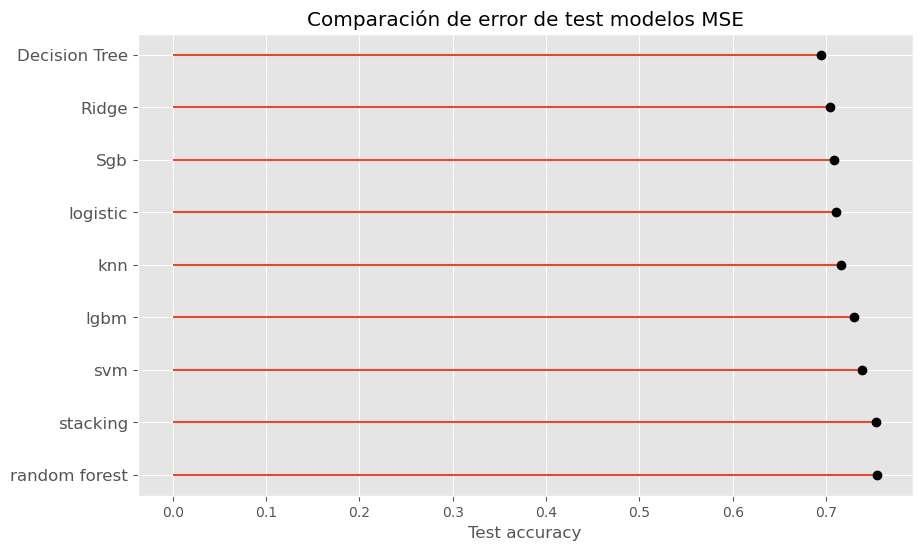

In [110]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'Ridge','logistic' ,'random forest', 'Sgb',"Decision Tree", "svm", 'lgbm','stacking'],
                              'Accuracy': [resul.iloc[2,0], resul.iloc[2,1], resul.iloc[1,2], resul.iloc[2,3], resul.iloc[1,4], resul.iloc[2,5],resul.iloc[1,6], resul.iloc[2,7] ,Accuracy_stacking]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)


plt.figure(figsize=(10, 6))
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación de error de test modelos MSE')
plt.xlabel('Test accuracy')

